In [ ]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.metrics import mean_squared_error

In [ ]:
def timer(start, end):
  """
  calculate time from start to end in hh:mm:ss.SS format
  based on https://stackoverflow.com/a/27780763/8653765
  """
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  return '{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds)

## Load MNIST dataset

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


4


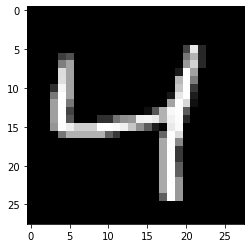

In [ ]:
print(y_train[2])
plt.imshow(X_train[2], cmap='gray')

In [ ]:
correct_train = []
for i in y_train:
  label = np.full(10, 0)
  label[i] = 1
  correct_train.append(label)

correct_test = []
for i in y_test:
  label = np.full(10, 0)
  label[i] = 1
  correct_test.append(label)

In [ ]:
correct_train[2]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

## Committee definition

In [ ]:
class Committee:
  def __init__(self, layout, n_NN, verbose=False):
    self.NNs = [ MLP(layout, verbose) for _ in range(n_NN) ]
    self.n_NN = n_NN
  
  def fit(self, X_train, y_train, X_test, y_test, eta=0.01, check_eta=10000, steps=100000, logs_by_steps=10000):
    start = time.time()
    for NN, i in zip(self.NNs, range(self.n_NN)):
      print(f'learn {i+1} NN')
      NN.fit(X_train, y_train, X_test, y_test, eta, check_eta, steps, logs_by_steps)
      print(f'{i+1} NN finish after {timer(start, time.time())}')
    print('================FINISH================')
    print(f'TRAIN: {self.predict_efficiency(X_train, y_train)}')
    print(f'TEST: {self.predict_efficiency(X_test, y_test)}')
    print(f'Time: {timer(start, time.time())}')
  
  def predict(self, sample):
    predicts = []
    for NN in self.NNs:
      predicts.append(NN.predict(sample))
    return np.bincount(predicts).argmax()
  
  def predict_efficiency(self, samples, labels):
    n_samples = samples.shape[0]
    n_correct_predict = 0
    predicts = []
    for sample, label in zip(samples, labels):
      predicts.append(self.predict(sample))
      if(predicts[-1] == np.argmax(label)):
        n_correct_predict = n_correct_predict + 1
    efficiency = n_correct_predict * 100.0/n_samples
    mse = mean_squared_error([np.argmax(l) for l in labels], predicts)
    return efficiency, mse

## Neural Network definition

In [ ]:
class MLP:
  def __init__(self, layout, verbose=False):
    self.layers = [ Layer(layout[i], layout[i+1]) for i in range(np.size(layout)-1) ]
    self.steps_results = []
    self.verbose = verbose
    if(self.verbose):
      print('new MLP ', end='')
      self.print_details()

  def fit(self, X_train, y_train, X_test, y_test, eta=0.01, check_eta=10000, steps=100000, logs_by_steps=10000):
    start = time.time()
    for i in range(steps):
      current_sample = np.random.randint(0, np.size(X_train, 1))
      self.backward(X_train[current_sample], y_train[current_sample], eta)
      if(i%logs_by_steps == 0):
        predict_train = self.predict_efficiency(X_train, y_train)
        predict_test = self.predict_efficiency(X_test, y_test)
        self.steps_results.append([i, predict_train, predict_test])
        if(self.verbose):
          print()
          print(f'Step: {i}, learning rate: {eta}')
          print('========================================')
          print('Correct predicts:')
          print(f'\ttrain data\t{round(predict_train[0], 2)}%\n\ttest data\t{round(predict_test[0], 2)}%')
          print('MSE:')
          print(f'\ttrain data\t{round(predict_train[1].sum(), 5)}\n\ttest data\t{round(predict_test[1].sum(), 5)}')
          print(f'Time: {timer(start, time.time())}')
      # if(i != 0 and i%check_eta == 0): # zmienić ten warunek - uzależnić od wyliczanego MSE
      if (i%check_eta == 0 and len(self.steps_results) > 1 and self.steps_results[-1][2][1] >= self.steps_results[-2][2][1]):
        eta = eta / 10.0
      if eta <= 1e-5:
        break
    predict_train = self.predict_efficiency(X_train, y_train)
    predict_test = self.predict_efficiency(X_test, y_test)
    self.steps_results.append([i, predict_train, predict_test])
    if(self.verbose):
      print()
      print(f'Learning finished after {steps} steps.')
      print('========================================')
      print('Correct predicts:')
      print(f'\train data\t{round(predict_train[0], 2)}%\n\ttest data\t{round(predict_test[0], 2)}%')
      print('MSE:')
      print(f'\ttrain data\t{round(predict_train[1].sum(), 5)}\n\ttest data\t{round(predict_test[1].sum(), 5)}')
      print(f'Time: {timer(start, time.time())}')
      self.plots()
  
  def backward(self, input, labels, eta):
    O = self.forward(input)
    ERR = labels - O
    for layer in reversed(self.layers):
      ERR = layer.backward(ERR, eta)
      ERR = ERR[1:]

  def forward(self, input):
    for layer in self.layers:
      input = layer.forward(input)
    return input

  def predict(self, sample):
    return np.argmax(self.forward(sample))

  def predict_efficiency(self, samples, labels):
    n_samples = samples.shape[0]
    n_correct_predict = 0
    predicts = []
    for sample, label in zip(samples, labels):
      predicts.append(self.predict(sample))
      if(predicts[-1] == np.argmax(label)):
        n_correct_predict = n_correct_predict + 1
    efficiency = n_correct_predict * 100.0/n_samples
    mse = mean_squared_error([np.argmax(l) for l in labels], predicts)
    return efficiency, mse

  def print_details(self):
    print(f'({self.layers[0].n_input}', end='')
    for layer in self.layers:
      print(f' -> {layer.n_output}', end='')
    print(')')

  def smooth_plots(self):
    steps = np.array([ self.steps_results[i][0] for i in range(len(self.steps_results)) ])
    xnew = np.linspace(steps.min(), steps.max(), 500)

    spl = make_interp_spline(steps, [ self.steps_results[i][1][0] for i in range(len(self.steps_results)) ], k=3)
    train_eff_smooth = spl(xnew)
    spl = make_interp_spline(steps, [ self.steps_results[i][2][0] for i in range(len(self.steps_results)) ], k=3)
    test_eff_smooth = spl(xnew)
    plt.plot(xnew, train_eff_smooth, label='train')
    plt.plot(xnew, test_eff_smooth, label='test')
    plt.title('Efficiency %')
    plt.legend()
    plt.show()

    spl = make_interp_spline(steps, [ self.steps_results[i][1][1] for i in range(len(self.steps_results)) ], k=3)
    train_mse_smooth = spl(xnew)
    spl = make_interp_spline(steps, [ self.steps_results[i][2][1] for i in range(len(self.steps_results)) ], k=3)
    test_mse_smooth = spl(xnew)
    plt.plot(xnew, train_mse_smooth, label='train')
    plt.plot(xnew, test_mse_smooth, label='test')
    plt.title('MSE')
    plt.legend()
    plt.show()
  
  def plots(self):
    steps = np.array([ self.steps_results[i][0] for i in range(len(self.steps_results)) ])

    plt.plot(steps, [ self.steps_results[i][1][0] for i in range(len(self.steps_results)) ], label='train')
    plt.plot(steps, [ self.steps_results[i][2][0] for i in range(len(self.steps_results)) ], label='test')
    plt.title('Efficiency %')
    plt.legend()
    plt.show()

    plt.plot(steps, [ self.steps_results[i][1][1] for i in range(len(self.steps_results)) ], label='train')
    plt.plot(steps, [ self.steps_results[i][2][1] for i in range(len(self.steps_results)) ], label='test')
    plt.title('MSE')
    plt.legend()
    plt.show()

## Single layer definition

In [ ]:
class Layer:
  def __init__(self, n_input, n_output):
    self.n_input = n_input
    self.n_output = n_output
    self.weights = np.random.normal(0, .1, (self.n_output, self.n_input + 1))
  
  def print_details(self):
    print(f'\t({self.n_input} -> {self.n_output})')

  def sigmoid(self, x):
    return 1/(1 + np.exp(-x))

  def sigmoid_1st_derivative(self, x):
    return self.sigmoid(x) * (1 - self.sigmoid(x))

  def tanh(self, x):
    return np.tanh(x)

  def tanh_1st_derivative(self, x):
    return 1 - np.power(np.tanh(x), 2)

  def softmax(self, x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
  def softmax_1st_derivative(self, x): # WRONG!
    x_tmp = x.reshape(-1,1)
    return np.diagflat(x_tmp) - np.dot(x_tmp, x_tmp.T)

  def backward(self, err, eta):
    delta = err * self.sigmoid_1st_derivative(self.out)
    delta = np.reshape(delta, (self.n_output, 1))
    self.weights += eta * delta * self.E
    return (np.dot(np.transpose(self.weights), delta)).flatten()

  def forward(self, input):
    self.E = np.append([1], input)
    self.out = np.dot(self.weights, self.E)
    return self.sigmoid(self.out)

## Learning

In [ ]:
NNs = []
committees = []

### Example 1

NN 784 + 800

10 000 steps

In [ ]:
NN_1 = MLP([28*28, 800, 10], True)
NN_1.fit(X_train.reshape(60000, 28*28)/255.0, correct_train, 
         X_test.reshape(10000, 28*28)/255.0, correct_test, 
         eta=0.01, check_eta=1000, steps=10000, logs_by_steps=100)
NNs.append(NN_1)
with open('NN_1.pkl', 'wb') as fid:
  pickle.dump(NN_1, fid)

### Example 2

NN 784 + 300

10 000 steps

In [ ]:
NN_2 = MLP([28*28, 300, 10], True)
NN_2.fit(X_train.reshape(60000, 28*28)/255.0, correct_train, 
         X_test.reshape(10000, 28*28)/255.0, correct_test, 
         eta=0.01, check_eta=1000, steps=10000, logs_by_steps=100)
NNs.append(NN_2)
with open('NN_2.pkl', 'wb') as fid:
  pickle.dump(NN_2, fid)

### Example 3

Committee of 25 NNs 784 + 300

10 000 steps

In [ ]:
committee_1 = Committee([28*28, 300, 10], 25)
committee_1.fit(X_train.reshape(60000, 28*28)/255.0, correct_train,
                X_test.reshape(10000, 28*28)/255.0, correct_test, 
                eta=0.01, check_eta=1000, steps=10000, logs_by_steps=10000)
committees.append(committee_1)
with open('committee_1.pkl', 'wb') as fid:
  pickle.dump(committee_1, fid)

### Example 4

NN 784 + 300

1 500 000 steps

new MLP (784 -> 300 -> 10)

Step: 0, learning rate: 0.01
Correct predicts:
	train data	11.04%
	test data	10.85%
MSE:
	train data	15.33003
	test data	15.4857
Time: 00:00:08.93

Step: 100000, learning rate: 0.01
Correct predicts:
	train data	86.81%
	test data	87.45%
MSE:
	train data	2.19193
	test data	2.1144
Time: 00:01:54.23

Step: 200000, learning rate: 0.01
Correct predicts:
	train data	87.06%
	test data	87.33%
MSE:
	train data	2.18238
	test data	2.1749
Time: 00:03:40.28

Step: 300000, learning rate: 0.001
Correct predicts:
	train data	87.11%
	test data	87.41%
MSE:
	train data	2.18123
	test data	2.1512
Time: 00:05:32.32

Step: 400000, learning rate: 0.001
Correct predicts:
	train data	87.1%
	test data	87.43%
MSE:
	train data	2.1879
	test data	2.1532
Time: 00:07:18.88

Step: 500000, learning rate: 0.0001
Correct predicts:
	train data	87.09%
	test data	87.44%
MSE:
	train data	2.18547
	test data	2.1551
Time: 00:09:05.03

Step: 600000, learning rate: 0.0001
Correct predicts:
	train data	8

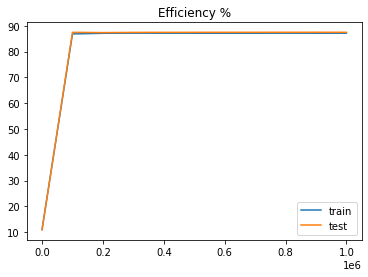

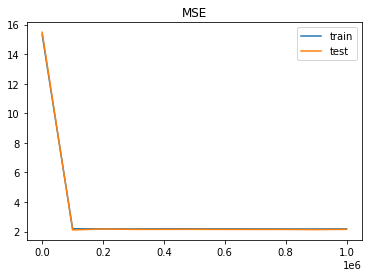

NameError: ignored

In [ ]:
NN_3 = MLP([28*28, 300, 10], True)
NN_3.fit(X_train.reshape(60000, 28*28)/255.0, correct_train, 
         X_test.reshape(10000, 28*28)/255.0, correct_test, 
         eta=0.01, check_eta=200000, steps=1500000, logs_by_steps=100000)
NNs.append(NN_3)
with open('NN_3.pkl', 'wb') as fid:
  pickle.dump(NN_3, fid)

### Example 5
NN 784 + 300 + 150

1 500 000 steps

In [ ]:
NN_4 = MLP([28*28, 300, 150, 10], True)
NN_4.fit(X_train.reshape(60000, 28*28)/255.0, correct_train, 
         X_test.reshape(10000, 28*28)/255.0, correct_test, 
         eta=0.01, check_eta=200000, steps=1500000, logs_by_steps=100000)
NNs.append(NN_4)
with open('NN_4.pkl', 'wb') as fid:
  pickle.dump(NN_4, fid)

### Example 6

Committee of 10 NNs 784 + 300 + 150

10 000 steps

In [ ]:
committee_2 = Committee([28*28, 300, 150, 10], 25)
committee_2.fit(X_train.reshape(60000, 28*28)/255.0, correct_train,
                X_test.reshape(10000, 28*28)/255.0, correct_test, 
                eta=0.01, check_eta=1000, steps=10000, logs_by_steps=10000)
committees.append(committee_2)
with open('committee_2.pkl', 'wb') as fid:
  pickle.dump(committee_2, fid)

### Example 7

Committee of 10 NNs 784 + 300

1 000 000 steps

In [ ]:
committee_3 = Committee([28*28, 300, 10], 10)
committee_3.fit(X_train.reshape(60000, 28*28)/255.0, correct_train,
                X_test.reshape(10000, 28*28)/255.0, correct_test, 
                eta=0.01, check_eta=250000, steps=1000000, logs_by_steps=250000)
committees.append(committee_3)
with open('committee_3.pkl', 'wb') as fid:
  pickle.dump(committee_3, fid)

### Example 7

NN 2500 + 1500 + 1000 + 500

1 000 000 steps

In [ ]:
NN_5 = MLP([28*28, 1500, 1000, 500, 10], True)
NN_5.fit(X_train.reshape(60000, 28*28)/255.0, correct_train, 
         X_test.reshape(10000, 28*28)/255.0, correct_test, 
         eta=0.001, check_eta=250000, steps=1000000, logs_by_steps=250000)
NNs.append(NN_5)
with open('NN_5.pkl', 'wb') as fid:
  pickle.dump(NN_5, fid)